# Sales Forecasting on Pesticide Sales

In [60]:
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [61]:
df= pd.read_excel('Sales_Forecast_Data.xlsx',parse_dates = True,squeeze= True)

In [62]:
df.head()

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE
0,2014-2015,Nov,Haryana,Insecticides,Rohtak,monous,675.00
1,2014-2015,Nov,Haryana,Insecticides,Rewari,monous,73.71
2,2014-2015,Nov,Haryana,Insecticides,Gurgaon,monous,405.00
3,2014-2015,Nov,Haryana,Insecticides,Mewat,monous,1188.00
4,2014-2015,Nov,Haryana,Insecticides,Palwal,monous,5188.59


In [63]:
df['FG'].value_counts()

Herbicides      57538
Bactericides    57538
Insecticides    57538
Rodenticides    57538
Name: FG, dtype: int64

In [64]:
df['COMPANY'].value_counts()

ABC Manufacturing    28640
trita                22744
cynoid               20800
disescent            17012
interosis            14288
idiombee             13904
exicious             12992
unimm                10184
scire                10152
zooloo               10032
unent                 9760
janu                  9432
hemify                7924
venible               7844
socimbee              6812
monous                4888
kadoo                 4272
flimbo                3476
intravu               3460
agizu                 2700
archile               1428
esose                 1056
munder                 820
dominive               580
suroid                 544
inent                  536
alboid                 512
yore                   468
biore                  464
hypomba                380
insulescent            328
falcize                240
centicee               240
oyofix                 220
ament                  212
canill                 200
luper                  116
t

# Data Preprocessing

## Creating the dataframe for ABC Manufacturing

In [65]:
df1= df[df['COMPANY']==('ABC Manufacturing')]

In [66]:
df1.head()

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE
49,2014-2015,Dec,Haryana,Insecticides,Ambala,ABC Manufacturing,6019.380
50,2014-2015,Dec,Haryana,Insecticides,Yamunanagar,ABC Manufacturing,425.250
51,2014-2015,Dec,Haryana,Insecticides,Karnal,ABC Manufacturing,14782.635
52,2014-2015,Dec,Haryana,Insecticides,Panipat,ABC Manufacturing,4031.910
53,2014-2015,Dec,Haryana,Insecticides,Sonipat,ABC Manufacturing,8692.110


We have 4 year pesticides Sales Data

In [67]:
df1.shape

(28640, 7)

### Adding Rainfall Data from 2014-2017 obtained from external source

In [68]:
rain= pd.read_excel('RAINFALL DATA_NORTHERN STATEW.xlsx')
rain.head(15)

,SUBDIVISION,YEAR,Month,Rainfall Data
0,Uttar Pradesh,2014,JAN,47.85
1,Uttar Pradesh,2014,FEB,27.60
2,Uttar Pradesh,2014,MAR,19.00
3,Uttar Pradesh,2014,APR,3.50
4,Uttar Pradesh,2014,MAY,10.85
5,Uttar Pradesh,2014,JUN,34.90
6,Uttar Pradesh,2014,JUL,188.05
7,Uttar Pradesh,2014,AUG,109.55
8,Uttar Pradesh,2014,SEP,95.70
9,Uttar Pradesh,2014,OCT,44.65


In [69]:
rain['Month']= rain['Month'].str.title()

In [70]:
rain

,SUBDIVISION,YEAR,Month,Rainfall Data
0,Uttar Pradesh,2014,Jan,47.85
1,Uttar Pradesh,2014,Feb,27.60
2,Uttar Pradesh,2014,Mar,19.00
3,Uttar Pradesh,2014,Apr,3.50
4,Uttar Pradesh,2014,May,10.85
...,...,...,...,...
235,Uttarakhand,2017,Aug,349.00
236,Uttarakhand,2017,Sep,213.40
237,Uttarakhand,2017,Oct,2.80
238,Uttarakhand,2017,Nov,0.20


In [71]:
rain['Year-Month']= rain['Month'].map(str)+ rain['YEAR'].map(str)

rain

,SUBDIVISION,YEAR,Month,Rainfall Data,Year-Month
0,Uttar Pradesh,2014,Jan,47.85,Jan2014
1,Uttar Pradesh,2014,Feb,27.60,Feb2014
2,Uttar Pradesh,2014,Mar,19.00,Mar2014
3,Uttar Pradesh,2014,Apr,3.50,Apr2014
4,Uttar Pradesh,2014,May,10.85,May2014
...,...,...,...,...,...
235,Uttarakhand,2017,Aug,349.00,Aug2017
236,Uttarakhand,2017,Sep,213.40,Sep2017
237,Uttarakhand,2017,Oct,2.80,Oct2017
238,Uttarakhand,2017,Nov,0.20,Nov2017


### Extracting Population and Area data from wikipwdia

In [72]:
htm= pd.read_html('https://en.wikipedia.org/wiki/List_of_states_and_union_territories_of_India_by_population')

In [73]:
len(htm)

htm[1]

pop_area=pd.DataFrame(htm[1])

pop_area.drop(['Rank','National Share (%)','Decadal growth(2001–2012)','Rural population','Percent rural','Urban population','Percent urban','Density[a]' ,'Sex ratio'],axis=1, inplace= True)

pop_area1= pop_area[pop_area['State or union territory'].isin(['Uttar Pradesh','Punjab','Haryana','Uttarakhand','Himachal Pradesh'])]

In [74]:
pop_area1['Area[16]']= pop_area['Area[16]'].str.split('km2',expand= True)

In [75]:
pop_area1['Area[16]']=pop_area1['Area[16]'].replace({',':'','km2':'','\xa0':'','\(.*?\)':'','(93023\xa0sq\xa0mi)':''}, regex=True).astype('float')

In [76]:
pop_area1

,State or union territory,Population,Area[16]
0,Uttar Pradesh,199812341,240928.0
15,Punjab,27743338,50362.0
17,Haryana,25351462,44212.0
20,Uttarakhand,10086292,53483.0
21,Himachal Pradesh,6864602,55673.0


In [77]:
lst_months=['Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df1 = df1[df1["MONTH"].isin(lst_months)]

In [78]:
df1.head()

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE
49,2014-2015,Dec,Haryana,Insecticides,Ambala,ABC Manufacturing,6019.380
50,2014-2015,Dec,Haryana,Insecticides,Yamunanagar,ABC Manufacturing,425.250
51,2014-2015,Dec,Haryana,Insecticides,Karnal,ABC Manufacturing,14782.635
52,2014-2015,Dec,Haryana,Insecticides,Panipat,ABC Manufacturing,4031.910
53,2014-2015,Dec,Haryana,Insecticides,Sonipat,ABC Manufacturing,8692.110


In [79]:
df1['Year-Month']= df['MONTH'] + df['FIN_YEAR'].str[:4]

In [80]:
df2=df[df['COMPANY'] == 'ABC Manufacturing']

In [81]:
lst_months_sec=['Jan','Feb','Mar']
df2 = df2[df2["MONTH"].isin(lst_months_sec)]

In [82]:
df2['Year-Month']= df2['MONTH'] + df2['FIN_YEAR'].str[5:]

In [83]:
new_df = pd.concat([df1, df2])

In [84]:
new_df

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE,Year-Month
49,2014-2015,Dec,Haryana,Insecticides,Ambala,ABC Manufacturing,6019.380,Dec2014
50,2014-2015,Dec,Haryana,Insecticides,Yamunanagar,ABC Manufacturing,425.250,Dec2014
51,2014-2015,Dec,Haryana,Insecticides,Karnal,ABC Manufacturing,14782.635,Dec2014
52,2014-2015,Dec,Haryana,Insecticides,Panipat,ABC Manufacturing,4031.910,Dec2014
53,2014-2015,Dec,Haryana,Insecticides,Sonipat,ABC Manufacturing,8692.110,Dec2014
...,...,...,...,...,...,...,...,...
230086,2016-2017,Feb,Punjab,Bactericides,Tarn Taran,ABC Manufacturing,0.000,Feb2017
230087,2016-2017,Feb,Punjab,Bactericides,Rupnagar,ABC Manufacturing,0.000,Feb2017
230088,2016-2017,Feb,Punjab,Bactericides,S.A.S Nagar,ABC Manufacturing,0.000,Feb2017
230089,2016-2017,Feb,Punjab,Bactericides,Sangrur,ABC Manufacturing,0.000,Feb2017


### Merging the original data,rainfall and Population-Area data based on State and Year-Month 

In [85]:
merg_df = pd.merge(new_df,rain,how= 'inner',left_on=['STATE','Year-Month'],right_on=['SUBDIVISION','Year-Month'])

In [86]:
merg_df.head()

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE,Year-Month,SUBDIVISION,YEAR,Month,Rainfall Data
0,2014-2015,Dec,Haryana,Insecticides,Ambala,ABC Manufacturing,6019.380,Dec2014,Haryana,2014,Dec,9.6
1,2014-2015,Dec,Haryana,Insecticides,Yamunanagar,ABC Manufacturing,425.250,Dec2014,Haryana,2014,Dec,9.6
2,2014-2015,Dec,Haryana,Insecticides,Karnal,ABC Manufacturing,14782.635,Dec2014,Haryana,2014,Dec,9.6
3,2014-2015,Dec,Haryana,Insecticides,Panipat,ABC Manufacturing,4031.910,Dec2014,Haryana,2014,Dec,9.6
4,2014-2015,Dec,Haryana,Insecticides,Sonipat,ABC Manufacturing,8692.110,Dec2014,Haryana,2014,Dec,9.6


In [87]:
merg_df = pd.merge(merg_df,pop_area1, how='inner', left_on= ['STATE'], right_on=['State or union territory'])

In [88]:
merg_df['Year-Month']= pd.to_datetime(merg_df['Year-Month'],infer_datetime_format=True)

In [89]:
merg_df

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE,Year-Month,SUBDIVISION,YEAR,Month,Rainfall Data,State or union territory,Population,Area[16]
0,2014-2015,Dec,Haryana,Insecticides,Ambala,ABC Manufacturing,6019.380,2014-12-01,Haryana,2014,Dec,9.6,Haryana,25351462,44212.0
1,2014-2015,Dec,Haryana,Insecticides,Yamunanagar,ABC Manufacturing,425.250,2014-12-01,Haryana,2014,Dec,9.6,Haryana,25351462,44212.0
2,2014-2015,Dec,Haryana,Insecticides,Karnal,ABC Manufacturing,14782.635,2014-12-01,Haryana,2014,Dec,9.6,Haryana,25351462,44212.0
3,2014-2015,Dec,Haryana,Insecticides,Panipat,ABC Manufacturing,4031.910,2014-12-01,Haryana,2014,Dec,9.6,Haryana,25351462,44212.0
4,2014-2015,Dec,Haryana,Insecticides,Sonipat,ABC Manufacturing,8692.110,2014-12-01,Haryana,2014,Dec,9.6,Haryana,25351462,44212.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28087,2016-2017,Mar,Uttarakhand,Bactericides,Champawat,ABC Manufacturing,0.000,2017-03-01,Uttarakhand,2017,Mar,44.5,Uttarakhand,10086292,53483.0
28088,2016-2017,Mar,Uttarakhand,Bactericides,Nainital,ABC Manufacturing,0.000,2017-03-01,Uttarakhand,2017,Mar,44.5,Uttarakhand,10086292,53483.0
28089,2016-2017,Mar,Uttarakhand,Bactericides,Haridwar,ABC Manufacturing,0.000,2017-03-01,Uttarakhand,2017,Mar,44.5,Uttarakhand,10086292,53483.0
28090,2016-2017,Mar,Uttarakhand,Bactericides,Uttar Kashi,ABC Manufacturing,0.000,2017-03-01,Uttarakhand,2017,Mar,44.5,Uttarakhand,10086292,53483.0


In [90]:
merg_df['Population'].value_counts()

199812341    12732
25351462      5944
6864602       3840
27743338      3584
10086292      1992
Name: Population, dtype: int64

In [91]:
merg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28092 entries, 0 to 28091
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   FIN_YEAR                  28092 non-null  object        
 1   MONTH                     28092 non-null  object        
 2   STATE                     28092 non-null  object        
 3   FG                        28092 non-null  object        
 4   DISTRICT                  28092 non-null  object        
 5   COMPANY                   28092 non-null  object        
 6   VALUE                     28092 non-null  float64       
 7   Year-Month                28092 non-null  datetime64[ns]
 8   SUBDIVISION               28092 non-null  object        
 9   YEAR                      28092 non-null  int64         
 10  Month                     28092 non-null  object        
 11  Rainfall Data             28092 non-null  float64       
 12  State or union ter

In [92]:
merg_df['Population']=merg_df.Population.astype(float)

Final Data after merging with rainfall,population and area.

# Data Visualization

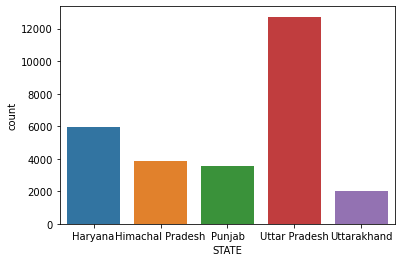

In [93]:
sns.countplot(x='STATE', data= merg_df)

In [94]:
merg_df['STATE'].value_counts(dropna= False)

Uttar Pradesh       12732
Haryana              5944
Himachal Pradesh     3840
Punjab               3584
Uttarakhand          1992
Name: STATE, dtype: int64

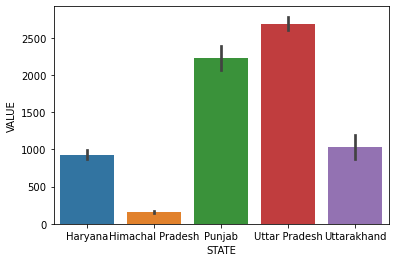

In [95]:
sns.barplot(x='STATE',y='VALUE',data= merg_df)

Uttarpradesh is the highest in consumption of the Pesticides. Punjab is the second in Pesticide consumption and Himachal Pradesh consumes least in all of these 5 Northern States

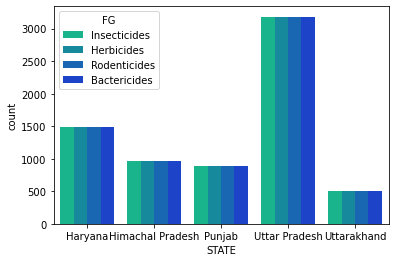

In [96]:
sns.countplot(x='STATE', hue='FG', data = merg_df, palette='winter_r')

There is Equal distribution of different category of Pesticides in every state based on their consumption. 

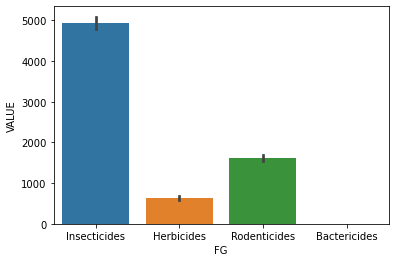

In [97]:
sns.barplot(x='FG',y='VALUE',data= merg_df)

As per the graph, ABC Manufacturing aren't supplying Bactericides whereas Insecticides accounts for the highest portion of the Sales.

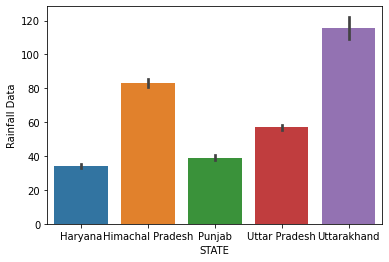

In [98]:
sns.barplot(x='STATE',y = 'Rainfall Data', data= merg_df)

Uttrakhand and Himachal Pradesh has the highest rainfall as compared to Uttarpradesh and Punjab which in turn has the highest pesticide consumption.

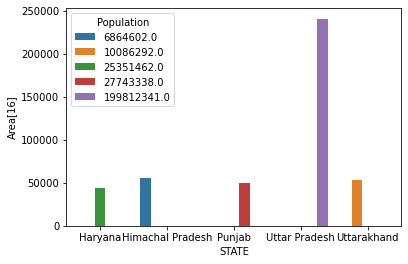

In [99]:
sns.barplot(x='STATE', y= 'Area[16]', hue='Population',data= merg_df)

In [100]:
merg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28092 entries, 0 to 28091
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   FIN_YEAR                  28092 non-null  object        
 1   MONTH                     28092 non-null  object        
 2   STATE                     28092 non-null  object        
 3   FG                        28092 non-null  object        
 4   DISTRICT                  28092 non-null  object        
 5   COMPANY                   28092 non-null  object        
 6   VALUE                     28092 non-null  float64       
 7   Year-Month                28092 non-null  datetime64[ns]
 8   SUBDIVISION               28092 non-null  object        
 9   YEAR                      28092 non-null  int64         
 10  Month                     28092 non-null  object        
 11  Rainfall Data             28092 non-null  float64       
 12  State or union ter

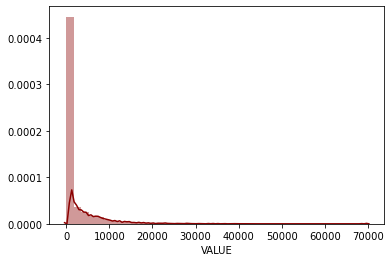

In [101]:
sns.distplot(merg_df['VALUE'],kde=True,color = 'darkred',bins=40)

Target variable i.e. Value is Right Skewed

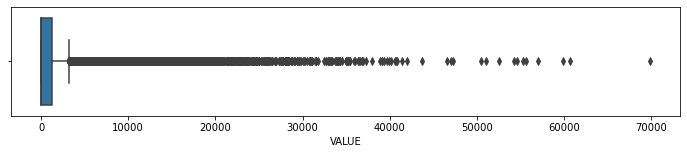

In [102]:
g = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=merg_df['VALUE'],whis=1.5)

In [103]:
merg_df['Year-Month'].value_counts()

2016-10-01    988
2016-12-01    972
2016-09-01    968
2016-06-01    940
2016-11-01    920
2016-07-01    920
2017-03-01    904
2017-01-01    884
2017-02-01    876
2016-08-01    844
2016-05-01    840
2017-11-01    560
2016-04-01    560
2017-12-01    556
2014-10-01    552
2017-06-01    548
2014-11-01    548
2015-10-01    544
2015-07-01    544
2015-08-01    540
2014-12-01    540
2017-07-01    540
2015-12-01    540
2015-11-01    540
2014-06-01    540
2014-08-01    540
2015-02-01    536
2017-09-01    536
2015-01-01    536
2016-02-01    536
2017-05-01    536
2015-09-01    536
2016-01-01    532
2015-06-01    532
2016-03-01    532
2014-07-01    528
2017-10-01    528
2014-09-01    524
2017-08-01    524
2015-05-01    512
2015-04-01    512
2015-03-01    492
2014-05-01    488
2017-04-01    480
2014-04-01    444
Name: Year-Month, dtype: int64

In [104]:
merg_df.isnull().sum()

FIN_YEAR                    0
MONTH                       0
STATE                       0
FG                          0
DISTRICT                    0
COMPANY                     0
VALUE                       0
Year-Month                  0
SUBDIVISION                 0
YEAR                        0
Month                       0
Rainfall Data               0
State or union territory    0
Population                  0
Area[16]                    0
dtype: int64

In [105]:
merg_df.corr()

,VALUE,YEAR,Rainfall Data,Population,Area[16]
VALUE,1.000000,-0.060921,-0.038300,0.196689,0.189013
YEAR,-0.060921,1.000000,0.007056,-0.077340,-0.075006
Rainfall Data,-0.038300,0.007056,1.000000,-0.025597,0.001392
Population,0.196689,-0.077340,-0.025597,1.000000,0.994402
Area[16],0.189013,-0.075006,0.001392,0.994402,1.000000


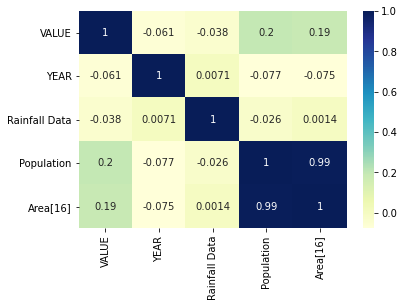

In [106]:
sns.heatmap(merg_df.corr(),annot= True,cmap="YlGnBu")

Rainfall has a low negative correlation with absolute value close to 0 with the Target variable. So, we can drop the rainfall data.

In [107]:
HR_rain =merg_df[merg_df['STATE'] == 'Haryana']

In [108]:
HR_rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5944 entries, 0 to 5943
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   FIN_YEAR                  5944 non-null   object        
 1   MONTH                     5944 non-null   object        
 2   STATE                     5944 non-null   object        
 3   FG                        5944 non-null   object        
 4   DISTRICT                  5944 non-null   object        
 5   COMPANY                   5944 non-null   object        
 6   VALUE                     5944 non-null   float64       
 7   Year-Month                5944 non-null   datetime64[ns]
 8   SUBDIVISION               5944 non-null   object        
 9   YEAR                      5944 non-null   int64         
 10  Month                     5944 non-null   object        
 11  Rainfall Data             5944 non-null   float64       
 12  State or union terri

In [109]:
HR_rain.corr()

,VALUE,YEAR,Rainfall Data,Population,Area[16]
VALUE,1.000000,-0.118551,-0.015975,NaN,NaN
YEAR,-0.118551,1.000000,-0.006553,NaN,NaN
Rainfall Data,-0.015975,-0.006553,1.000000,NaN,NaN
Population,NaN,NaN,NaN,NaN,NaN
Area[16],NaN,NaN,NaN,NaN,NaN


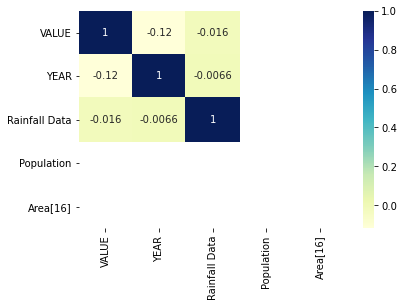

In [110]:
sns.heatmap(HR_rain.corr(),annot= True,cmap="YlGnBu")

In [111]:
UP_rain= merg_df[merg_df['STATE']==('Uttar Pradesh')]

PJ_rain= merg_df[merg_df['STATE']==('Punjab')]

UK_rain= merg_df[merg_df['STATE']==('Uttarakhand')]

HP_rain= merg_df[merg_df['STATE']==('Himachal Pradesh')]

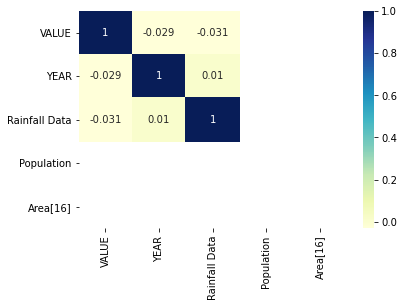

In [112]:
sns.heatmap(UP_rain.corr(), annot =True, cmap='YlGnBu')

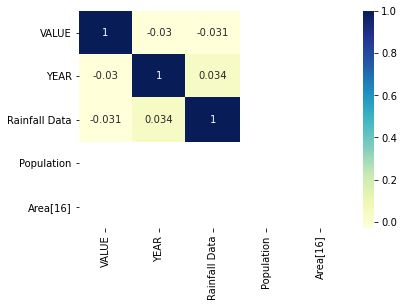

In [113]:
sns.heatmap(PJ_rain.corr(), annot =True, cmap='YlGnBu')

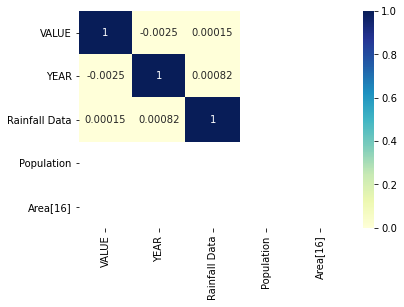

In [114]:
sns.heatmap(UK_rain.corr(), annot =True, cmap='YlGnBu')

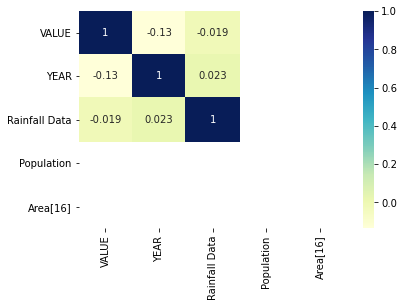

In [115]:
sns.heatmap(HP_rain.corr(), annot =True, cmap='YlGnBu')

In [116]:
new_df['Year-Month']= pd.to_datetime(new_df['Year-Month'],infer_datetime_format=True)

## Checking if the data is Stationary by using Augmneted Dickey Fuller Test

In [117]:
X= new_df.VALUE
result = adfuller(X)

In [118]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.136218
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.

In [119]:
new_df = new_df.sort_values('Year-Month')

In [120]:
new_df

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE,Year-Month
119264,2014-2015,Apr,Uttar Pradesh,Rodenticides,Kanpur Dehat,ABC Manufacturing,25.650,2014-04-01
118547,2014-2015,Apr,Uttar Pradesh,Rodenticides,Gautam Buddha Nagar,ABC Manufacturing,0.000,2014-04-01
118546,2014-2015,Apr,Uttar Pradesh,Rodenticides,Ghaziabad,ABC Manufacturing,190.485,2014-04-01
118545,2014-2015,Apr,Uttar Pradesh,Rodenticides,Baghpat,ABC Manufacturing,82.080,2014-04-01
118544,2014-2015,Apr,Uttar Pradesh,Rodenticides,Meerut,ABC Manufacturing,85.995,2014-04-01
...,...,...,...,...,...,...,...,...
51514,2017-2018,Jan,Uttar Pradesh,Insecticides,Unnao,ABC Manufacturing,24476.850,2018-01-01
51515,2017-2018,Jan,Uttar Pradesh,Insecticides,Lucknow,ABC Manufacturing,8613.000,2018-01-01
51516,2017-2018,Jan,Uttar Pradesh,Insecticides,Rae Bareli,ABC Manufacturing,15958.890,2018-01-01
51510,2017-2018,Jan,Uttar Pradesh,Insecticides,Shahjahanpur,ABC Manufacturing,19044.450,2018-01-01


In [121]:
new_df.drop(['FIN_YEAR','MONTH','FG','DISTRICT','COMPANY'],axis=1,inplace =True)

In [122]:
new_df

,STATE,VALUE,Year-Month
119264,Uttar Pradesh,25.650,2014-04-01
118547,Uttar Pradesh,0.000,2014-04-01
118546,Uttar Pradesh,190.485,2014-04-01
118545,Uttar Pradesh,82.080,2014-04-01
118544,Uttar Pradesh,85.995,2014-04-01
...,...,...,...
51514,Uttar Pradesh,24476.850,2018-01-01
51515,Uttar Pradesh,8613.000,2018-01-01
51516,Uttar Pradesh,15958.890,2018-01-01
51510,Uttar Pradesh,19044.450,2018-01-01


## Segmentation based on States 

In [123]:
HR=new_df[new_df['STATE'] == 'Haryana']

UP= new_df[new_df['STATE']==('Uttar Pradesh')]

PJ= new_df[new_df['STATE']==('Punjab')]

UK= new_df[new_df['STATE']==('Uttarakhand')]

HP= new_df[new_df['STATE']==('Himachal Pradesh')]

In [124]:
HR

,STATE,VALUE,Year-Month
175640,Haryana,0.00,2014-04-01
175641,Haryana,0.00,2014-04-01
175642,Haryana,0.00,2014-04-01
175643,Haryana,0.00,2014-04-01
175644,Haryana,0.00,2014-04-01
...,...,...,...
51895,Haryana,7995.24,2018-01-01
51894,Haryana,5064.93,2018-01-01
51893,Haryana,6092.82,2018-01-01
51892,Haryana,216.00,2018-01-01


In [125]:
UP

,STATE,VALUE,Year-Month
119264,Uttar Pradesh,25.650,2014-04-01
118547,Uttar Pradesh,0.000,2014-04-01
118546,Uttar Pradesh,190.485,2014-04-01
118545,Uttar Pradesh,82.080,2014-04-01
118544,Uttar Pradesh,85.995,2014-04-01
...,...,...,...
51513,Uttar Pradesh,15608.295,2018-01-01
51514,Uttar Pradesh,24476.850,2018-01-01
51515,Uttar Pradesh,8613.000,2018-01-01
51516,Uttar Pradesh,15958.890,2018-01-01


In [126]:
HR=HR.groupby('Year-Month')['VALUE'].sum().reset_index()

UP=UP.groupby('Year-Month')['VALUE'].sum().reset_index()

PJ=PJ.groupby('Year-Month')['VALUE'].sum().reset_index()

UK=UK.groupby('Year-Month')['VALUE'].sum().reset_index()

HP=HP.groupby('Year-Month')['VALUE'].sum().reset_index()

In [127]:

HR=  HR.set_index('Year-Month')

UP=  UP.set_index('Year-Month')

PJ=  PJ.set_index('Year-Month')

UK=  UK.set_index('Year-Month')

HP=  HP.set_index('Year-Month')

In [128]:
HR

,VALUE
Year-Month,
2014-04-01,32577.660
2014-05-01,47482.740
2014-06-01,130684.185
2014-07-01,75471.075
2014-08-01,107146.530
2014-09-01,138232.710
2014-10-01,168045.030
2014-11-01,175710.870
2014-12-01,127656.945


In [129]:
UP

,VALUE
Year-Month,
2014-04-01,142695.000
2014-05-01,395083.710
2014-06-01,553862.070
2014-07-01,720928.080
2014-08-01,1103308.965
2014-09-01,752904.720
2014-10-01,708021.540
2014-11-01,1431476.820
2014-12-01,1049625.270


Resampling the data based on MS- Monthly Start

In [130]:
y= UP['VALUE'].resample('MS').mean()

y1= HR['VALUE'].resample('MS').mean()

y2= PJ['VALUE'].resample('MS').mean()

y3= UK['VALUE'].resample('MS').mean()

y4= HP['VALUE'].resample('MS').mean()

## Visualizing Pesticides Sales

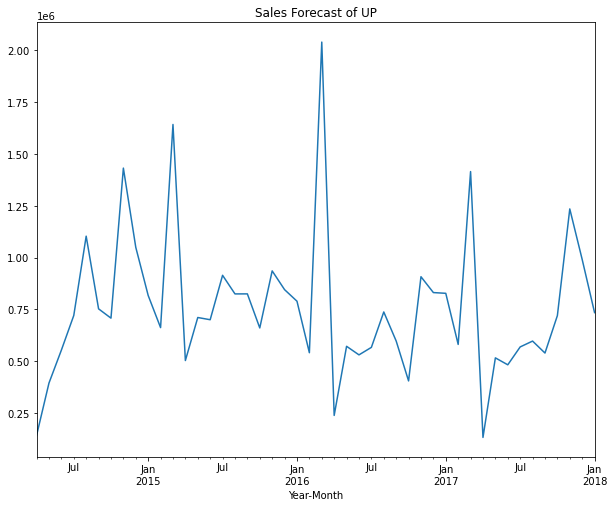

In [131]:
y.plot(figsize=(10,8))
plt.title('Sales Forecast of UP')
plt.show()

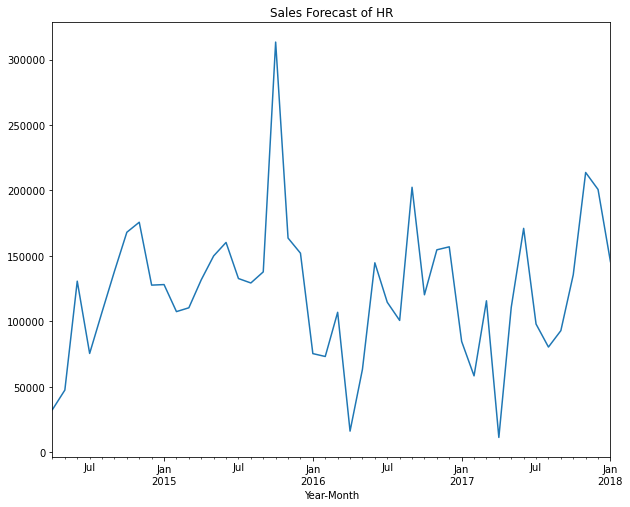

In [132]:

y1.plot(figsize=(10,8))
plt.title('Sales Forecast of HR')
plt.show()

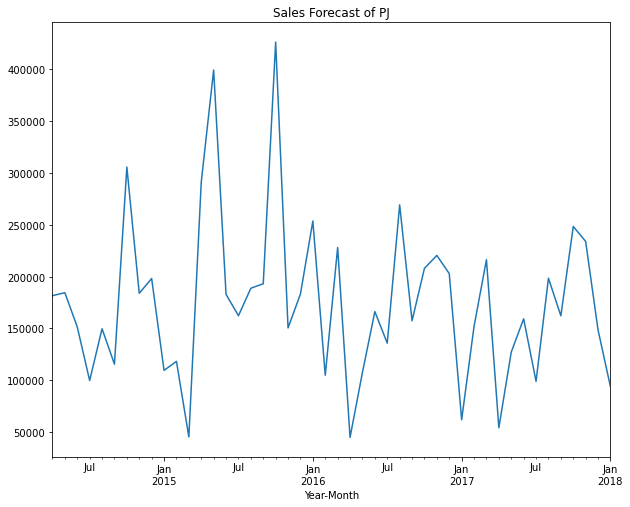

In [133]:

y2.plot(figsize=(10,8))
plt.title('Sales Forecast of PJ')
plt.show()

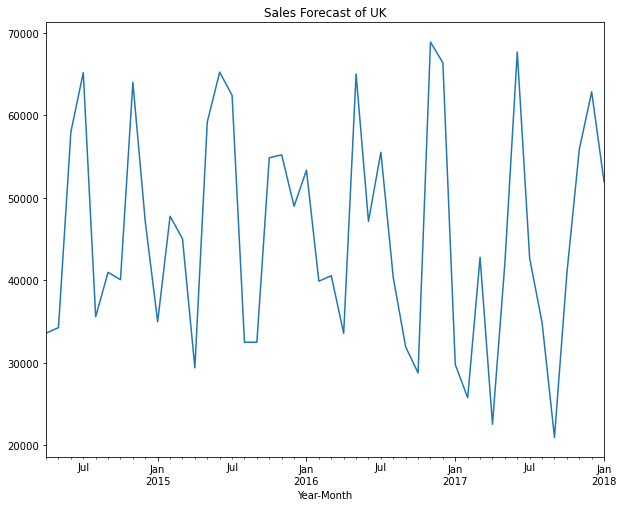

In [134]:

y3.plot(figsize=(10,8))
plt.title('Sales Forecast of UK')
plt.show()

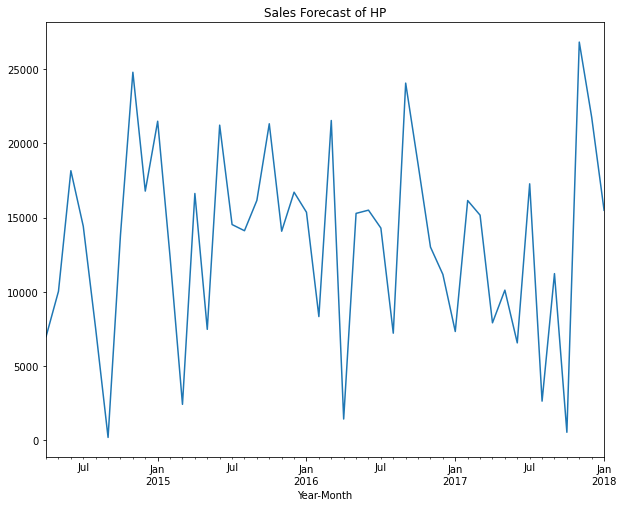

In [135]:

y4.plot(figsize=(10,8))
plt.title('Sales Forecast of HP')
plt.show()

There are distinguishable patterns appear when we plot the data.
The time-series has seasonality pattern.

Checking our data with a method called Decompostion. It will allows us to decompose the time series data into three distinct components trend,seasonality and noise

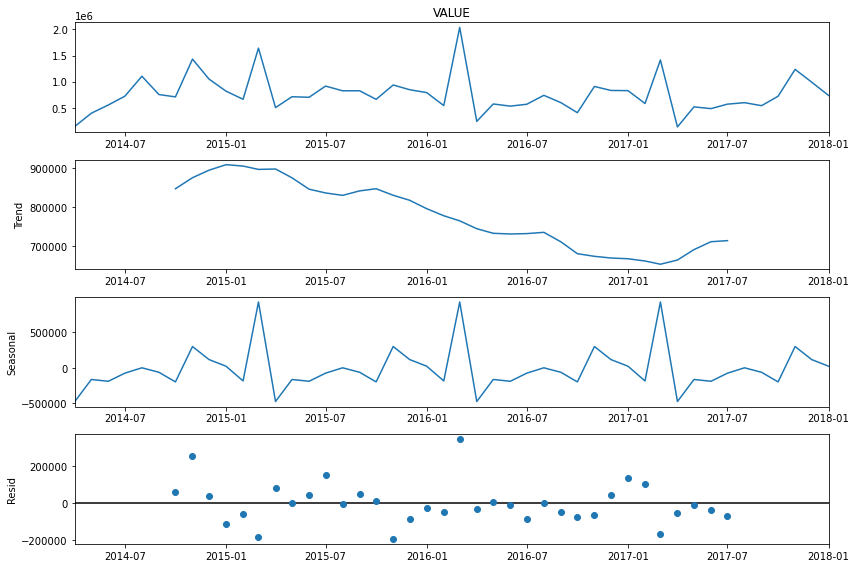

In [136]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] =12,8
decomposition = sm.tsa.seasonal_decompose(y,model= 'additive')
fig= decomposition.plot()
plt.show()

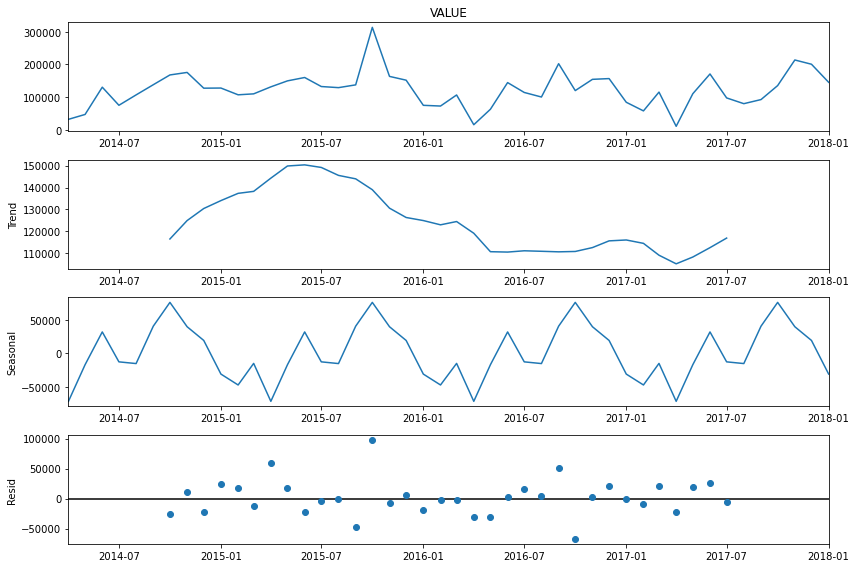

In [137]:
rcParams['figure.figsize'] =12,8
decomposition = sm.tsa.seasonal_decompose(y1,model= 'additive')
fig= decomposition.plot()
plt.show()

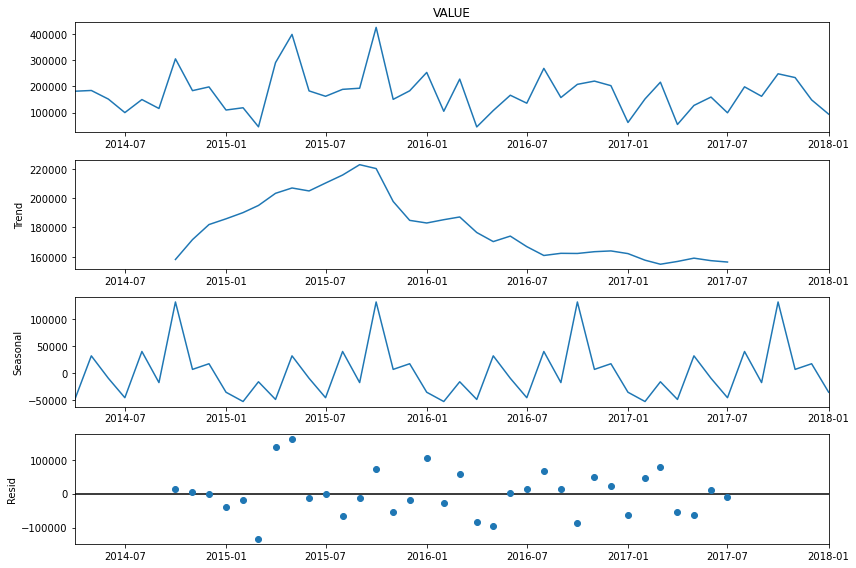

In [138]:
rcParams['figure.figsize'] =12,8
decomposition = sm.tsa.seasonal_decompose(y2,model= 'additive')
fig= decomposition.plot()
plt.show()

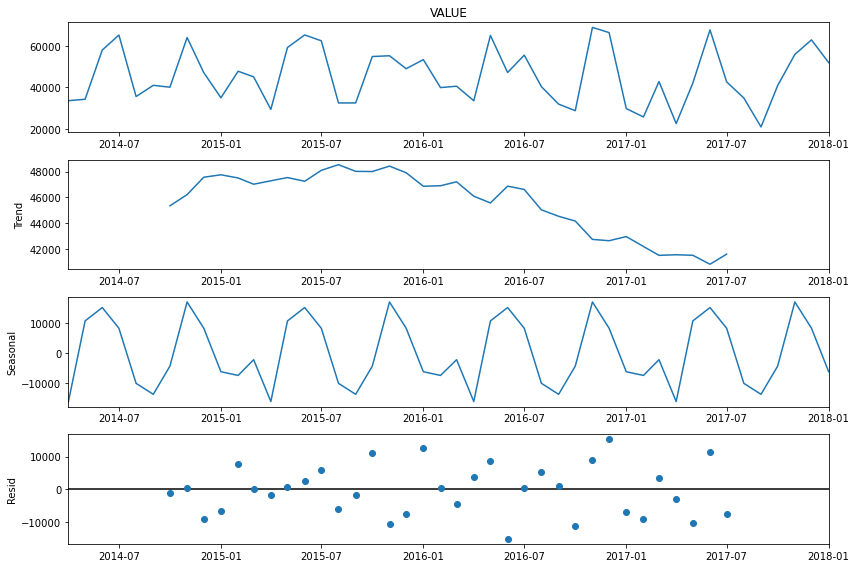

In [139]:
rcParams['figure.figsize'] =12,8
decomposition = sm.tsa.seasonal_decompose(y3,model= 'additive')
fig= decomposition.plot()
plt.show()

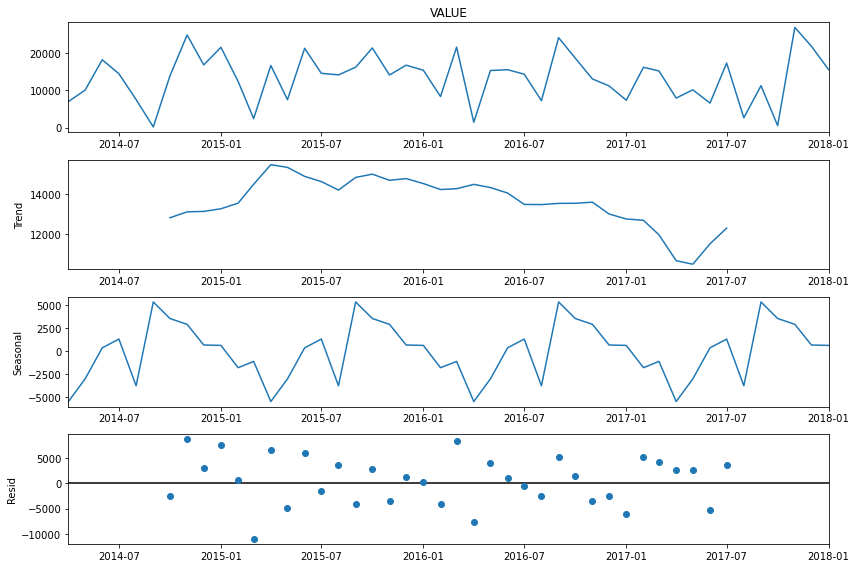

In [140]:
rcParams['figure.figsize'] =12,8
decomposition = sm.tsa.seasonal_decompose(y4,model= 'additive')
fig= decomposition.plot()
plt.show()

The plots above clearly shows that the sales are uncertain, along with its  seasonality.

## Split the Train and Test Data  based on States

In [141]:
train_len = 38
train = y[0:train_len]
test = y[train_len:]

In [142]:
train_len1 = 38
train1 = y1[0:train_len1]
test1 = y1[train_len1:]

In [143]:
train_len2 = 38
train2 = y2[0:train_len2]
test2 = y2[train_len2:]

In [144]:
train_len3 = 38
train3 = y3[0:train_len3]
test3 = y3[train_len3:]

In [145]:
train_len4 = 38
train4 = y4[0:train_len4]
test4 = y4[train_len4:]

In [146]:
train

Year-Month
2014-04-01     142695.000
2014-05-01     395083.710
2014-06-01     553862.070
2014-07-01     720928.080
2014-08-01    1103308.965
2014-09-01     752904.720
2014-10-01     708021.540
2014-11-01    1431476.820
2014-12-01    1049625.270
2015-01-01     817419.600
2015-02-01     662409.630
2015-03-01    1641843.540
2015-04-01     503665.560
2015-05-01     711111.285
2015-06-01     700414.290
2015-07-01     914662.530
2015-08-01     824892.660
2015-09-01     825032.385
2015-10-01     660813.660
2015-11-01     935888.850
2015-12-01     845433.045
2016-01-01     789729.885
2016-02-01     541337.310
2016-03-01    2039066.595
2016-04-01     239000.760
2016-05-01     572291.325
2016-06-01     531000.900
2016-07-01     567115.020
2016-08-01     737854.650
2016-09-01     597814.560
2016-10-01     405397.035
2016-11-01     907754.040
2016-12-01     831337.992
2017-01-01     827758.980
2017-02-01     581322.015
2017-03-01    1414752.183
2017-04-01     132897.240
2017-05-01     516515.670
F

In [147]:
test

Year-Month
2017-06-01     483089.130
2017-07-01     569271.915
2017-08-01     597466.935
2017-09-01     539775.090
2017-10-01     720295.875
2017-11-01    1234663.965
2017-12-01     991006.515
2018-01-01     734645.700
Freq: MS, Name: VALUE, dtype: float64

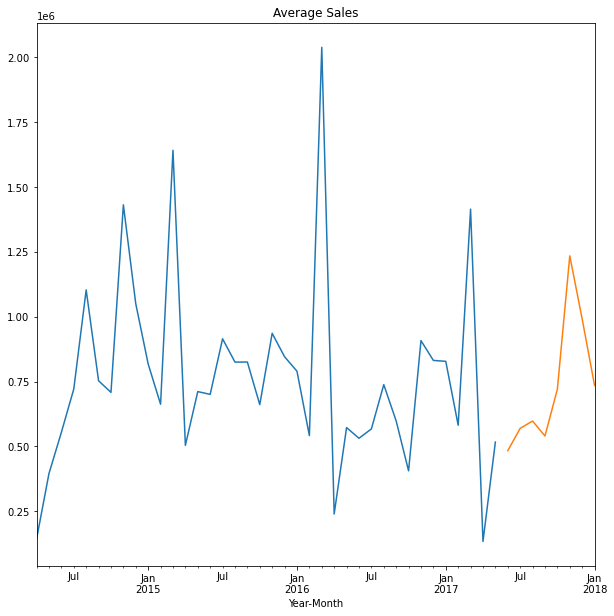

In [148]:
train.plot(figsize=(10,10), title='Average Sales')
test.plot(figsize=(10,10), title='Average Sales')

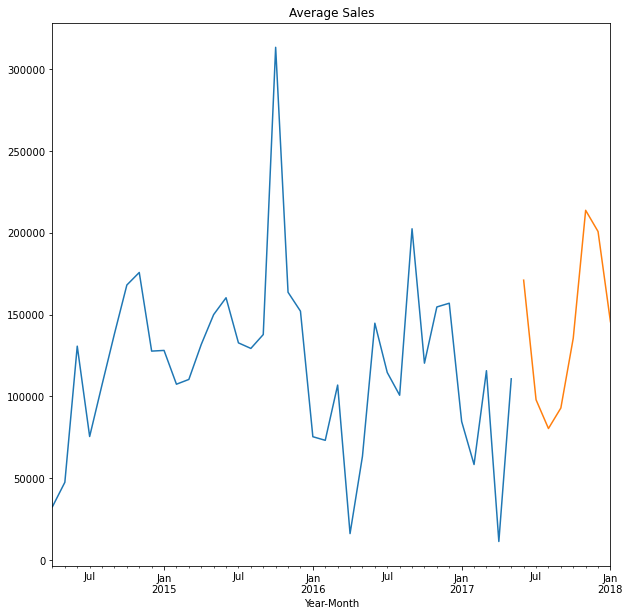

In [149]:
train1.plot(figsize=(10,10), title='Average Sales')
test1.plot(figsize=(10,10), title='Average Sales')

# Model Building

### Holt Winters' additive method with trend and seasonality

In [150]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
y_hat_hwa = y.copy()

In [151]:
model = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=12 ,trend='add', seasonal='add')

In [152]:
model_fit = model.fit(optimized=True)
print(model_fit.params)

{'smoothing_level': 0.3040638918158412, 'smoothing_slope': 2.4054638319759194e-15, 'smoothing_seasonal': 1.5063106616921598e-07, 'damping_slope': nan, 'initial_level': 171998.59105019987, 'initial_slope': 1466.0453841462845, 'initial_seasons': array([  70304.57952625,  314519.4093907 ,  330933.85984238,
        466363.45337435,  611471.15432354,  474612.76824263,
        390184.06592434,  908002.58918307,  708060.47392134,
        586582.2781648 ,  376208.5736046 , 1490097.28428563]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [153]:
y_hat_pred = model_fit.forecast(46)

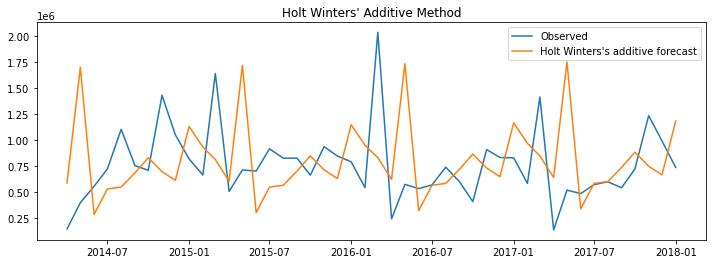

In [154]:
plt.figure(figsize=(12,4))
plt.plot(y.index,y, label='Observed')
plt.plot(y_hat_hwa.index,y_hat_pred, label='Holt Winters\'s additive forecast')
plt.title('Holt Winters\' Additive Method')
plt.legend(loc='best')
plt.show()

In [155]:
rmse = np.sqrt(mean_squared_error(y_hat_hwa, y_hat_pred)).round(2)

In [156]:
print(rmse)

512811.74


In [157]:
mape = np.round(np.mean(np.abs(y_hat_hwa-y_hat_pred)/y_hat_hwa)*100,2)

In [158]:
print(mape)

68.97


In [159]:
from statsmodels.tsa.arima_model import ARIMA

In [160]:
model = ARIMA(y, order=(0,1,1))

In [161]:
m1 = model.fit()

In [162]:
print(m1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.VALUE   No. Observations:                   45
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -641.311
Method:                       css-mle   S.D. of innovations         358572.471
Date:                Mon, 10 May 2021   AIC                           1288.623
Time:                        10:19:50   BIC                           1294.043
Sample:                    05-01-2014   HQIC                          1290.643
                         - 01-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1431.6675   3982.295     -0.360      0.719   -9236.822    6373.487
ma.L1.D.VALUE    -1.0000      0.070    -14.185      0.000      -1.138      -0.862
                                    Root

In [163]:
y_hat= y.copy()
y_hat['arima forecast'] = m1.predict(36)

In [164]:
print(y_hat)

Year-Month
2014-04-01 00:00:00                                               142695
2014-05-01 00:00:00                                               395084
2014-06-01 00:00:00                                               553862
2014-07-01 00:00:00                                               720928
2014-08-01 00:00:00                                          1.10331e+06
2014-09-01 00:00:00                                               752905
2014-10-01 00:00:00                                               708022
2014-11-01 00:00:00                                          1.43148e+06
2014-12-01 00:00:00                                          1.04963e+06
2015-01-01 00:00:00                                               817420
2015-02-01 00:00:00                                               662410
2015-03-01 00:00:00                                          1.64184e+06
2015-04-01 00:00:00                                               503666
2015-05-01 00:00:00                     

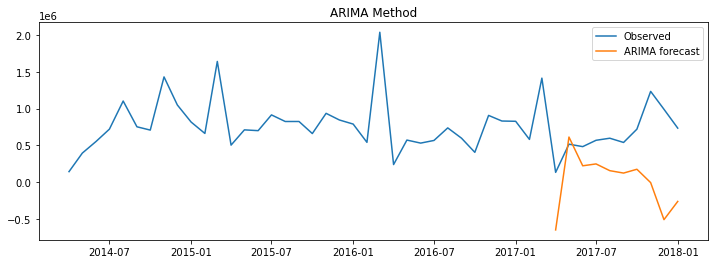

In [165]:
plt.figure(figsize=(12,4))
plt.plot(y, label='Observed')
plt.plot(y_hat['arima forecast'], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARIMA Method')
plt.show()

ARIMA didn't work as there is a seasonality involved. We will move with SARIMA

## Time series forecasting with SARIMA

In [166]:
import itertools

In [167]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Using a “grid search” to find the optimal set of parameters that yields the best performance for our model

In [168]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1358.3563883309002
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10478172.095364133
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:911.6109265342633
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:568.25560537259
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:937.059825673362
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:914.3627206347429
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:602.7008852639436
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:569.8509782590293
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1315.3176451717113
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:10322025.44121604
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:882.4554967116904
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:541.0305563893872
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:999.7638705322505
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:943.2506732561679
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:604.0065194093434
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:542.6966421616173
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1287.3671105922695
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3328774.124086339
ARIMA(0, 

The above output suggests that ARIMA(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 248.85. Therefore we should consider this to be optimal option.

In [169]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod1 = sm.tsa.statespace.SARIMAX(y1,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results1 = mod1.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results1.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1193.3588114279141
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:191398.9742929355
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:826.009484973081
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:518.1633664498069
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:852.1267289385912
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:173893.29935937613
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:542.2523817076109
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:519.6055616655792
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1144.842751765099
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:189083.52367081447
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:799.9593560681546
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:495.5322740736133
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:878.3757673013909
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:147893.68433658825
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:546.1022547647655
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:497.1497652970307
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1096.8348423230527
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:18811.50327661639
ARIMA(

The above output suggests that ARIMA(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 227.088. Therefore we should consider this to be optimal option.    

In [170]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod2 = sm.tsa.statespace.SARIMAX(y2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results2 = mod2.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results2.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1224.9091840487254
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:385173.79690492386
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:862.565800319478
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:537.6306663760582
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:886.4542626893609
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1039.7812573409763
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:568.1649781183652
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:539.618526861926
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1179.0798857027498
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:351073.32173991523
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:833.7059685288386
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:511.04194259959183
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:905.097954915501
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:852.7738641489634
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:571.1895857890819
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:511.6426688621058
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1149.0040988659648
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:135262.7345630139
ARIMA(

The above output suggests that ARIMA(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 239.17. Therefore we should consider this to be optimal option.    

In [171]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod3 = sm.tsa.statespace.SARIMAX(y3,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results3 = mod3.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results3.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1099.4023132587022
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:809.3561733810709
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:723.9575093319811
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:460.6492085600159
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:745.6156988797468
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:943.0454654954086
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:479.18507861180325
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:460.3107309582286
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1049.4513570222607
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:22207.792282664588
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:699.350643924701
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:437.83929808238156
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:801.0685394825617
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:23752.493680545267
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:481.59863311992933
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:437.19964323553666
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:987.1744249735362
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:797.3992913511149
ARI

The above output suggests that ARIMA(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 204.90. Therefore we should consider this to be optimal option.    

In [172]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod4 = sm.tsa.statespace.SARIMAX(y4,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results4 = mod4.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results4.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:995.1335202589979
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:895.1935784208057
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:695.6163104652268
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:439.59034339813957
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:715.8885794516351
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1117.7825581800673
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:463.8903888166886
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:441.3134877241686
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:959.2242892417459
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5484.744397424639
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:677.0769959832423
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:421.2138486391491
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:732.6407364360651
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:12399.63257568745
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:465.83035207592485
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:422.88928019792456
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:933.6179208291911
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1317.753759506109
ARIMA(

The above output suggests that ARIMA(0, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 192.76. Therefore we should consider this to be optimal option.    


### Fitting the SARIMA model

In [173]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              VALUE   No. Observations:                   46
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -255.454
Date:                            Mon, 10 May 2021   AIC                            516.907
Time:                                    10:20:14   BIC                            519.741
Sample:                                04-01-2014   HQIC                           517.387
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4309      0.489      0.881      0.378      -0.528       1.390
ma.S.L12      -0.4671      0.201   

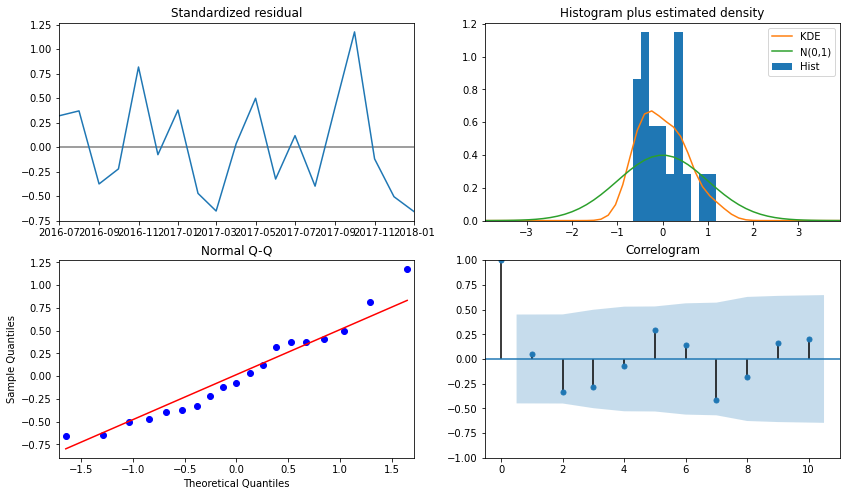

In [174]:
results.plot_diagnostics(figsize=(14, 8))
plt.show()

The Normal Q-Q plot shows that the ordered distribution of residuals follows the distribution similar to normal distribution.

In [175]:
mod1 = sm.tsa.statespace.SARIMAX(y1,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results1 = mod1.fit()
print(results1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              VALUE   No. Observations:                   46
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -233.284
Date:                            Mon, 10 May 2021   AIC                            472.568
Time:                                    10:20:15   BIC                            475.402
Sample:                                04-01-2014   HQIC                           473.048
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0161      0.023    -44.649      0.000      -1.061      -0.971
ma.S.L12      -0.6643      0.285   

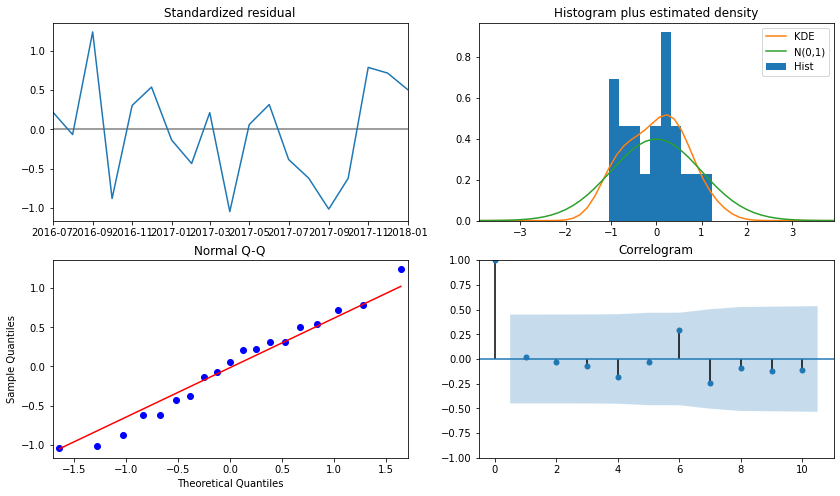

In [176]:
results1.plot_diagnostics(figsize=(14, 8))
plt.show()

In [177]:
mod2 = sm.tsa.statespace.SARIMAX(y2,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              VALUE   No. Observations:                   46
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -243.483
Date:                            Mon, 10 May 2021   AIC                            492.966
Time:                                    10:20:16   BIC                            495.799
Sample:                                04-01-2014   HQIC                           493.446
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8093      0.274     -2.949      0.003      -1.347      -0.271
ma.S.L12      -0.4654      0.363   

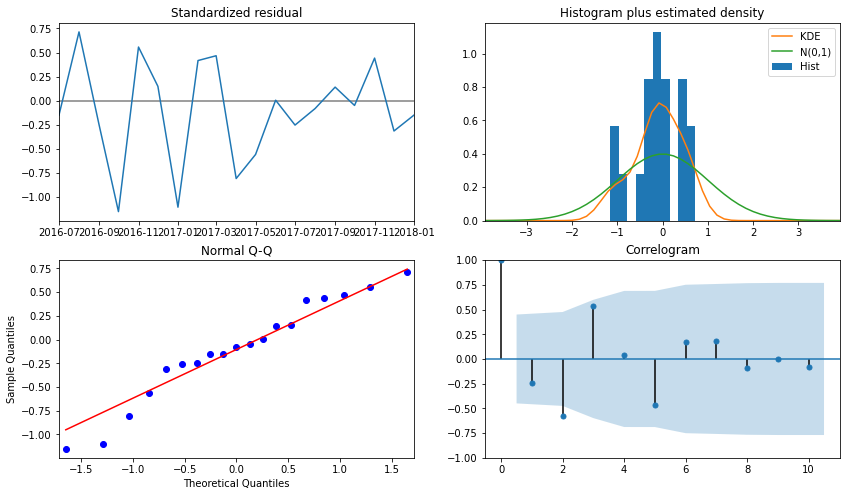

In [178]:
results2.plot_diagnostics(figsize=(14, 8))
plt.show()

In [179]:
mod3 = sm.tsa.statespace.SARIMAX(y3,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results3 = mod3.fit()
print(results3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              VALUE   No. Observations:                   46
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -209.426
Date:                            Mon, 10 May 2021   AIC                            424.852
Time:                                    10:20:16   BIC                            427.685
Sample:                                04-01-2014   HQIC                           425.331
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1875      0.178     -6.688      0.000      -1.535      -0.839
ma.S.L12      -0.3065      0.342   

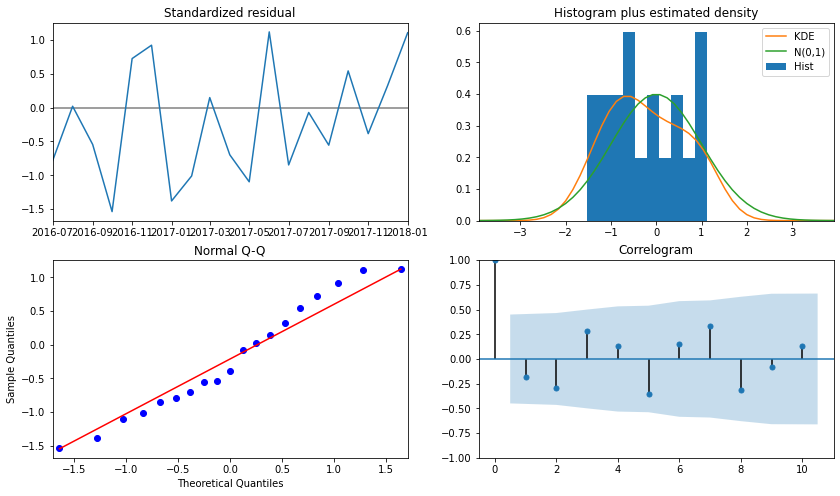

In [180]:
results3.plot_diagnostics(figsize=(14, 8))
plt.show()

In [181]:
mod4 = sm.tsa.statespace.SARIMAX(y4,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results4 = mod4.fit()
print(results4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              VALUE   No. Observations:                   46
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -199.112
Date:                            Mon, 10 May 2021   AIC                            404.224
Time:                                    10:20:17   BIC                            407.057
Sample:                                04-01-2014   HQIC                           404.704
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7998      0.261     -3.062      0.002      -1.312      -0.288
ma.S.L12      -0.9192      0.418   

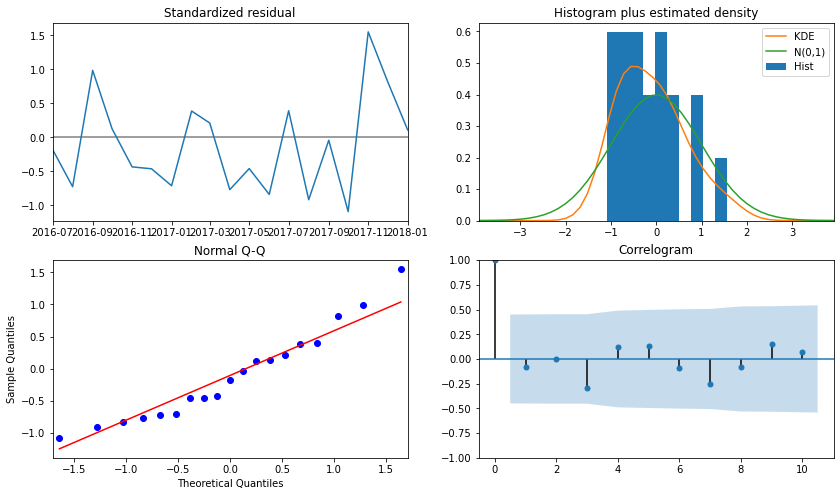

In [182]:
results4.plot_diagnostics(figsize=(14, 8))
plt.show()

## Validating forecasts

To check the accuracy of our forecasts,
we compare predicted sales to real sales of the time series,
and we set forecasts to start at 2017–01–01 to the end of the data.

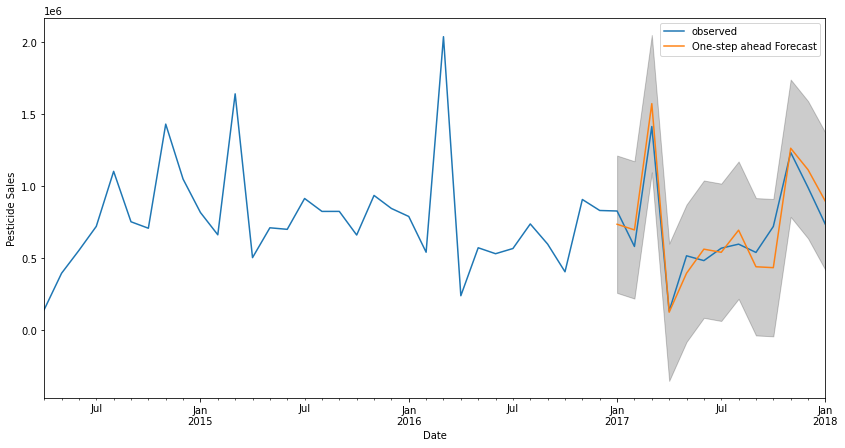

In [183]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=10, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.20)
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

In [184]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 16311161277.48


In [185]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 3)))

The Root Mean Squared Error of our forecasts is 127715.157


In [186]:
mape_s = np.round(np.mean(np.abs(y_truth-y_forecasted)/y_truth)*100,2)

In [187]:
print(mape_s)

15.74


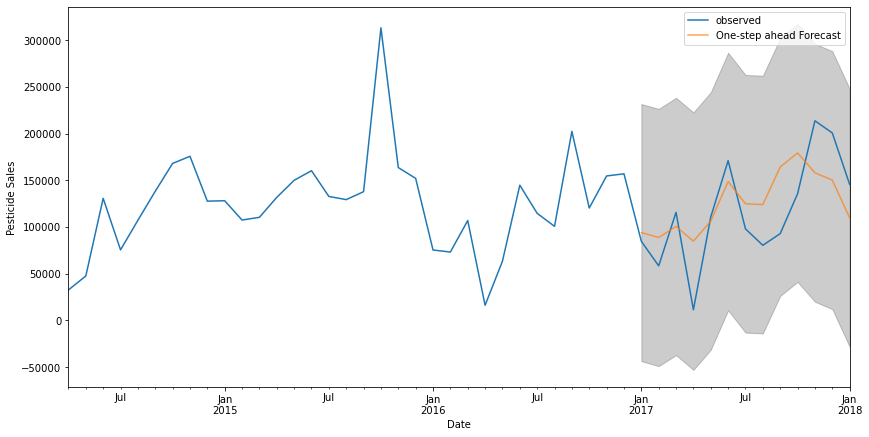

In [188]:
pred1 = results1.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci1 = pred1.conf_int()
ax = y1['2014':].plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.20)
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

In [189]:
y_forecasted1 = pred1.predicted_mean
y_truth1 = y1['2017-01-01':]
mse1 = ((y_forecasted1 - y_truth1)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse1, 2)))

The Mean Squared Error of our forecasts is 1824376588.94


In [190]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse1), 3)))

The Root Mean Squared Error of our forecasts is 42712.722


In [191]:
mape_s1 = np.round(np.mean(np.abs(y_truth1-y_forecasted1)/y_truth1)*100,2)
print(mape_s1)

77.65


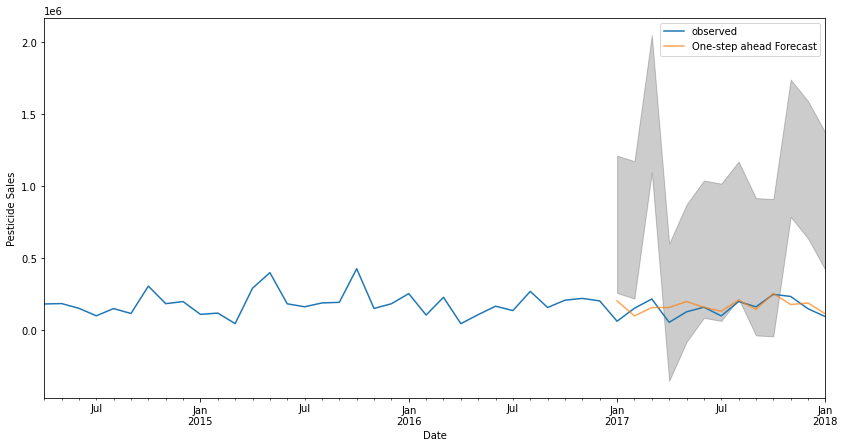

In [192]:
pred2 = results2.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci2 = pred.conf_int()
ax = y2['2014':].plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.20)
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

In [193]:
y_forecasted2 = pred2.predicted_mean
y_truth2 = y2['2017-01-01':]
mse2 = ((y_forecasted2 - y_truth2)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse2, 2)))

The Mean Squared Error of our forecasts is 3756855889.32


In [194]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse2), 3)))

The Root Mean Squared Error of our forecasts is 61293.196


In [195]:
mape_s2 = np.round(np.mean(np.abs(y_truth2-y_forecasted2)/y_truth2)*100,2)
print(mape_s2)

50.91


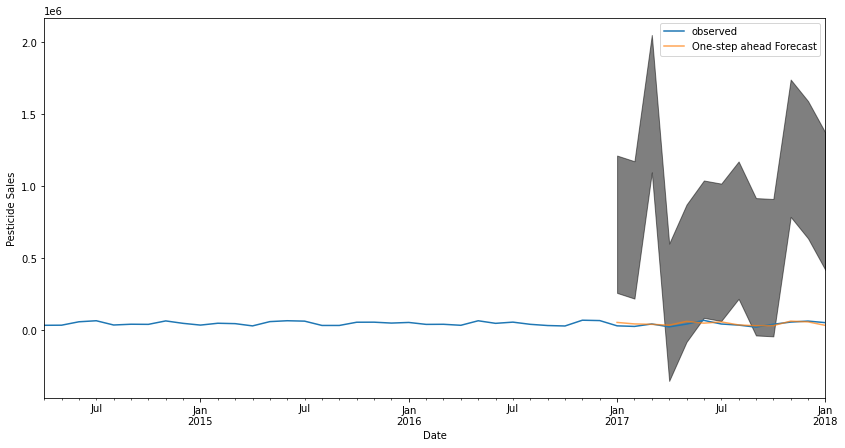

In [196]:
pred3 = results3.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci3 = pred.conf_int()
ax = y3['2014':].plot(label='observed')
pred3.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.50)
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

In [197]:
y_forecasted3 = pred3.predicted_mean
y_truth3 = y3['2017-01-01':]
mse3 = ((y_forecasted3 - y_truth3)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse3, 2)))

The Mean Squared Error of our forecasts is 197533174.16


In [198]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse3), 3)))

The Root Mean Squared Error of our forecasts is 14054.65


In [199]:
mape_s3 = np.round(np.mean(np.abs(y_truth3-y_forecasted3)/y_truth3)*100,2)

In [200]:
print(mape_s3)

34.08


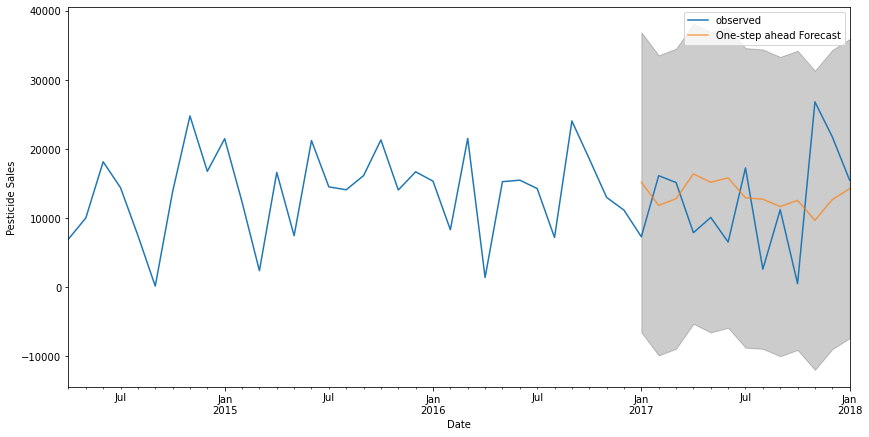

In [201]:
pred4 = results4.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci4 = pred4.conf_int()
ax = y4['2014':].plot(label='observed')
pred4.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci4.index,
                pred_ci4.iloc[:, 0],
                pred_ci4.iloc[:, 1], color='k', alpha=.20)
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

In [202]:
y_forecasted4 = pred4.predicted_mean
y_truth4 = y4['2017-01-01':]
mse4 = ((y_forecasted4 - y_truth4)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse4, 2)))

The Mean Squared Error of our forecasts is 70471552.32


In [203]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse4), 3)))

The Root Mean Squared Error of our forecasts is 8394.734


In [204]:
mape_s4 = np.round(np.mean(np.abs(y_truth4-y_forecasted4)/y_truth4)*100,2)
print(mape_s4)

256.46


### Prediction for next 5months

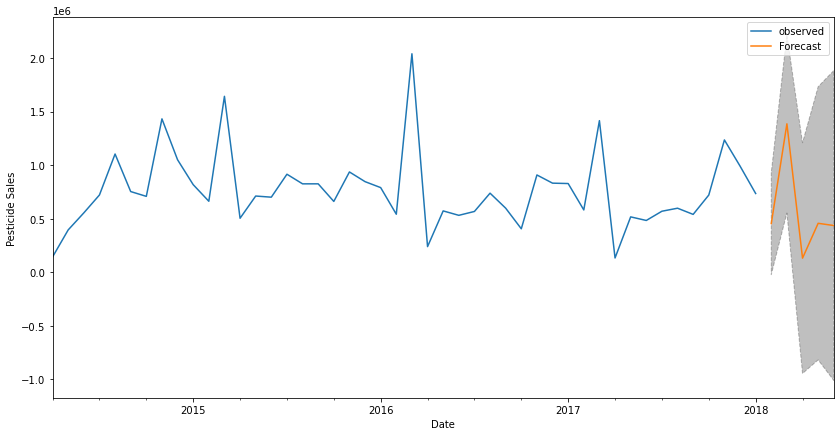

In [205]:
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed',figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25,ls='--')
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

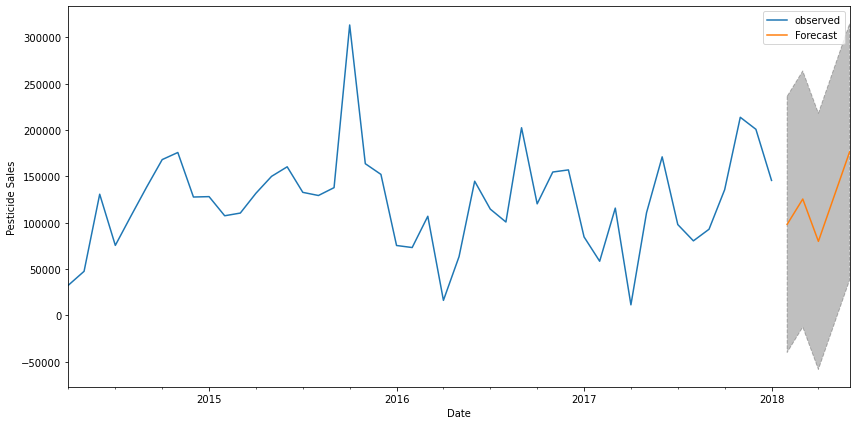

In [206]:
pred_uc1 = results1.get_forecast(steps=5)
pred_ci1 = pred_uc1.conf_int()
ax = y1.plot(label='observed',figsize=(14, 7))
pred_uc1.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.25,ls='--')
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

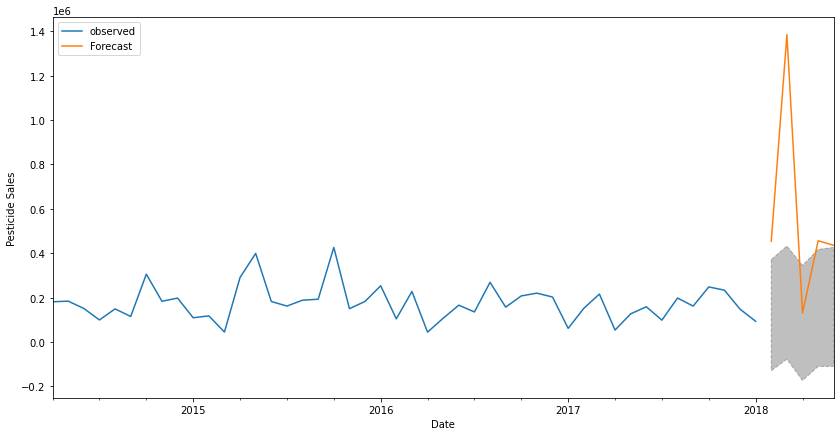

In [207]:
pred_uc2 = results2.get_forecast(steps=5)
pred_ci2 = pred_uc2.conf_int()
ax = y2.plot(label='observed',figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25,ls='--')
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

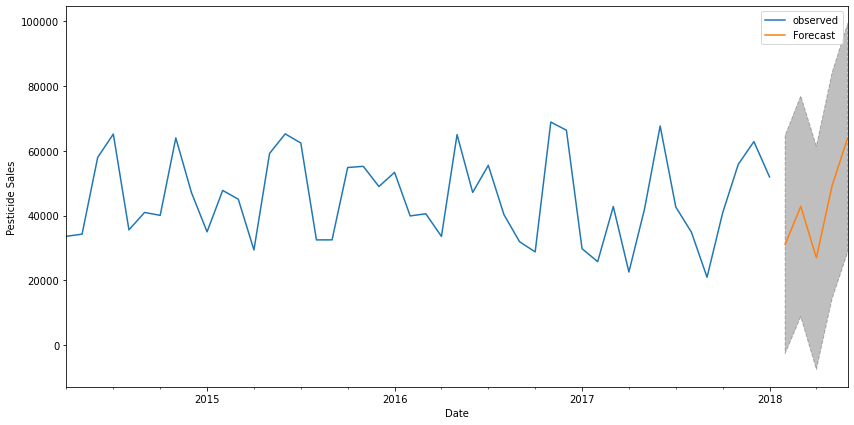

In [208]:
pred_uc3 = results3.get_forecast(steps=5)
pred_ci3 = pred_uc3.conf_int()
ax = y3.plot(label='observed',figsize=(14, 7))
pred_uc3.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.25,ls='--')
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

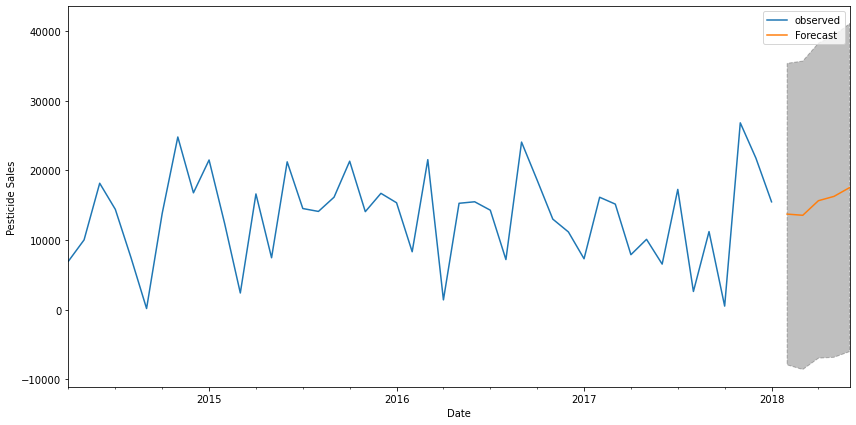

In [209]:
pred_uc4 = results4.get_forecast(steps=5)
pred_ci4 = pred_uc4.conf_int()
ax = y4.plot(label='observed',figsize=(14, 7))
pred_uc4.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci4.index,
                pred_ci4.iloc[:, 0],
                pred_ci4.iloc[:, 1], color='k', alpha=.25,ls='--')
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well.


## visualizing forecasts

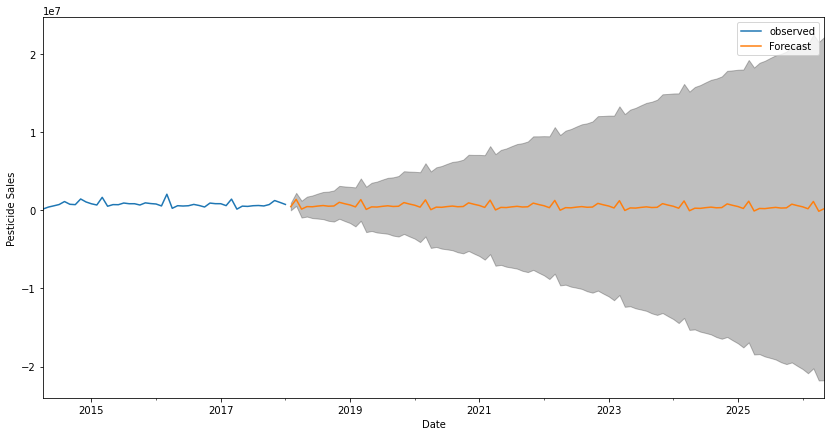

In [210]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Pesticide Sales')
plt.legend()
plt.show()

 There is an upward trend in sales in the coming years.

## Time Series Forecasting with Prophet

In [211]:
from fbprophet import Prophet

In [212]:
HR1=new_df[new_df['STATE'] == 'Haryana']

UP1= new_df[new_df['STATE']==('Uttar Pradesh')]

PJ1= new_df[new_df['STATE']==('Punjab')]

UK1= new_df[new_df['STATE']==('Uttarakhand')]

HP1= new_df[new_df['STATE']==('Himachal Pradesh')]

In [213]:
HR1.drop('STATE',axis=1,inplace= True)

In [214]:
UP1.drop('STATE',axis=1,inplace= True)
PJ1.drop('STATE',axis=1,inplace= True)
UK1.drop('STATE',axis=1,inplace= True)
HP1.drop('STATE',axis=1,inplace= True)

In [215]:
HR1.columns= ['y','ds']

In [216]:
UP1.columns= ['y','ds']
PJ1.columns= ['y','ds']
UK1.columns= ['y','ds']
HP1.columns= ['y','ds']

In [217]:
UP1.head()

,y,ds
119264,25.650,2014-04-01
118547,0.000,2014-04-01
118546,190.485,2014-04-01
118545,82.080,2014-04-01
118544,85.995,2014-04-01


In [218]:
UK1.head()

,y,ds
7727,24.300,2014-04-01
7728,189.000,2014-04-01
7729,224.100,2014-04-01
7730,17655.165,2014-04-01
7731,12217.500,2014-04-01


In [219]:
HR1.head()

,y,ds
175640,0.0,2014-04-01
175641,0.0,2014-04-01
175642,0.0,2014-04-01
175643,0.0,2014-04-01
175644,0.0,2014-04-01


In [220]:
UP1= UP1.groupby('ds')['y'].sum().reset_index()

UP1= UP1.set_index('ds')

UP1.index

DatetimeIndex(['2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [221]:
ABC_model = Prophet(interval_width=0.95)
ABC_model.fit(HR1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [222]:
ABC_future = ABC_model.make_future_dataframe(periods=5,freq= 'MS')

In [223]:
ABC_forecast = ABC_model.predict(ABC_future)

Text(0.5, 1.0, 'Pesticide Sales')

<Figure size 1296x432 with 0 Axes>

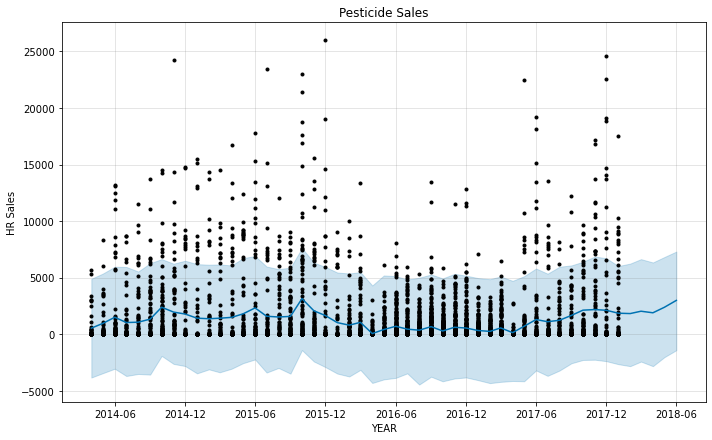

In [224]:
plt.figure(figsize=(18, 6))
ABC_model.plot(ABC_forecast, xlabel = 'YEAR', ylabel = 'HR Sales')
plt.title('Pesticide Sales')

In [225]:
ABC_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-04-01,1001.588329,-3829.155428,4900.653366,1001.588329,1001.588329,-465.583073,-465.583073,-465.583073,-465.583073,-465.583073,-465.583073,0.0,0.0,0.0,536.005256
1,2014-05-01,1066.934363,-3440.795918,5360.783746,1066.934363,1066.934363,-108.316339,-108.316339,-108.316339,-108.316339,-108.316339,-108.316339,0.0,0.0,0.0,958.618023
2,2014-06-01,1134.458597,-3049.151791,5962.775198,1134.458597,1134.458597,363.151063,363.151063,363.151063,363.151063,363.151063,363.151063,0.0,0.0,0.0,1497.609660
3,2014-07-01,1199.804556,-3691.244292,5945.002183,1199.804556,1199.804556,-166.569807,-166.569807,-166.569807,-166.569807,-166.569807,-166.569807,0.0,0.0,0.0,1033.234749
4,2014-08-01,1267.328713,-3512.285286,5540.982598,1267.328713,1267.328713,-204.423877,-204.423877,-204.423877,-204.423877,-204.423877,-204.423877,0.0,0.0,0.0,1062.904836


In [226]:
ABC_forecast[['ds','yhat']]

,ds,yhat
0,2014-04-01,536.005256
1,2014-05-01,958.618023
2,2014-06-01,1497.609660
3,2014-07-01,1033.234749
4,2014-08-01,1062.904836
5,2014-09-01,1333.066841
6,2014-10-01,2385.036795
7,2014-11-01,1955.792139
8,2014-12-01,1784.123768
9,2015-01-01,1418.524945


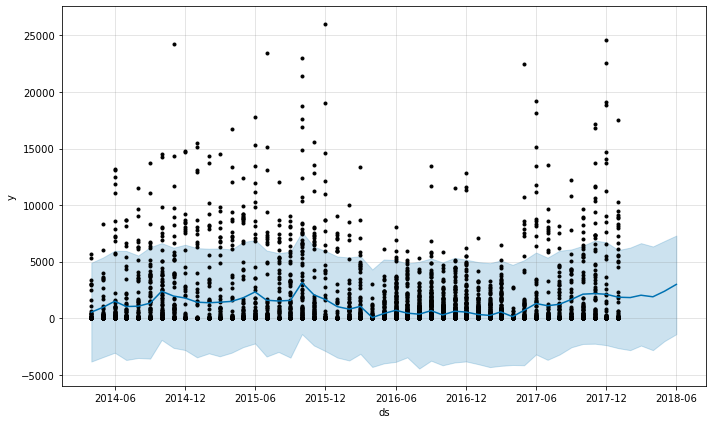

In [227]:
plot1= ABC_model.plot(ABC_forecast)

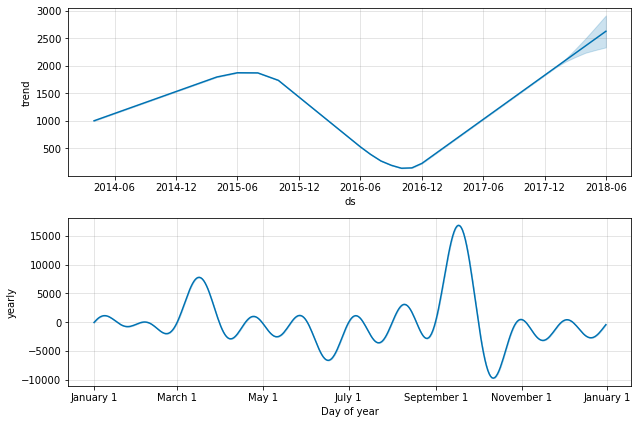

In [228]:
plot2= ABC_model.plot_components(ABC_forecast)

In [229]:
# Checking the RMSE of Prophet model
metric_prophet_1 = ABC_forecast.set_index('ds')[['yhat']].join(HR1.set_index('ds').y).reset_index()
metric_prophet_1.dropna(inplace=True)

In [230]:
rms_prophet_1 = mean_squared_error(metric_prophet_1.y, metric_prophet_1.yhat)

In [231]:
rms_prophet_1

5315086.527997505

In [232]:
mape_prop = np.round(np.mean(np.abs(metric_prophet_1.yhat-metric_prophet_1.y)/metric_prophet_1.yhat)*100,2)
print(mape_prop)

137.72


## Conclusion

As per the observation, the RMSE for ARIMA is less than prophet modeling. So, we can go ahead with SARIMA model. 